In [612]:
#TIME SERIES ANALYSIS OF STOCK PRICES (TATA GLOBAL BEVERAGES)

#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# matplotlib legends
import matplotlib.patches as mpatches

# Importing the data set from Quandl

### The daily stock prices of "TATA Global Beverages" on the National Stock Exchange of India from 2013-2018

In [613]:
# reading from file
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df = df.rename(columns = {'Total Trade Quantity':'Last Total Vol. Traded', 'Turnover (Lacs)': 'Last Turnover (100,000 INR)'})
df

,Date,Open,High,Low,Last,Close,Last Total Vol. Traded,"Last Turnover (100,000 INR)"
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
...,...,...,...,...,...,...,...,...
1230,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09
1231,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76
1232,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80
1233,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49


## Preliminary data cleaning

### Setting the date-time format and using it as the index

In [614]:
#setting date format
df['Date'] = pd.to_datetime(df.Date, format = '%Y-%m-%d')
df.index = df['Date']

### Plotting the "Closing Day" price of the stock over the 5 year period

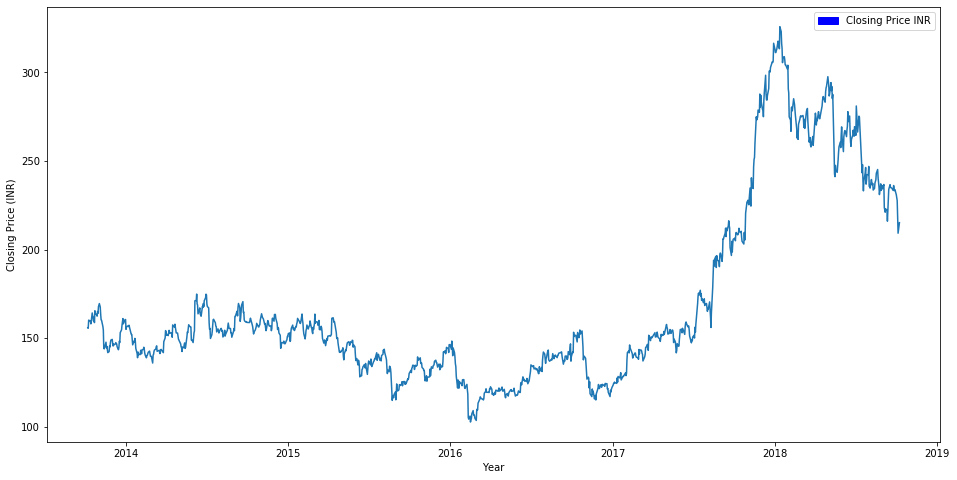

In [615]:
# plotting closing prices
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel('Year')
plt.ylabel('Closing Price (INR)')

# labeling
blue_patch = mpatches.Patch(color='blue', label='Closing Price INR')
plt.legend(handles=[blue_patch])

## Approach 1: Tracking seasonality changes using Moving Averages

In [616]:
# creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]


# print(new_data)

# NOTE: While splitting the data into train and validation set, we cannot use random splitting since 
# that will destroy the time component. So here we have set the last year’s data into validation 
# and the 4 years’ data before that into train set.

# splitting into train and validation (80-20) split
train = new_data[:987]
valid = new_data[987:]

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)

# Now to create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

# print(train)
# print(valid)


# checking the results (RMSE value)
rms = np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)

# print(np.mean(np.count_nonzero(valid['Close'] == preds)))


 Shape of training set:
(987, 2)

 Shape of validation set:
(248, 2)

 RMSE value on validation set:
104.51415465984348


### As expected this naive approach performs poorly on the validation set. 

### It is very insensitive to price changes and thus can't track seasonality. A suitable RMSE would lie between 15-30 units, but here we see it is 104.51.

### This can also be inferred from the graph below:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


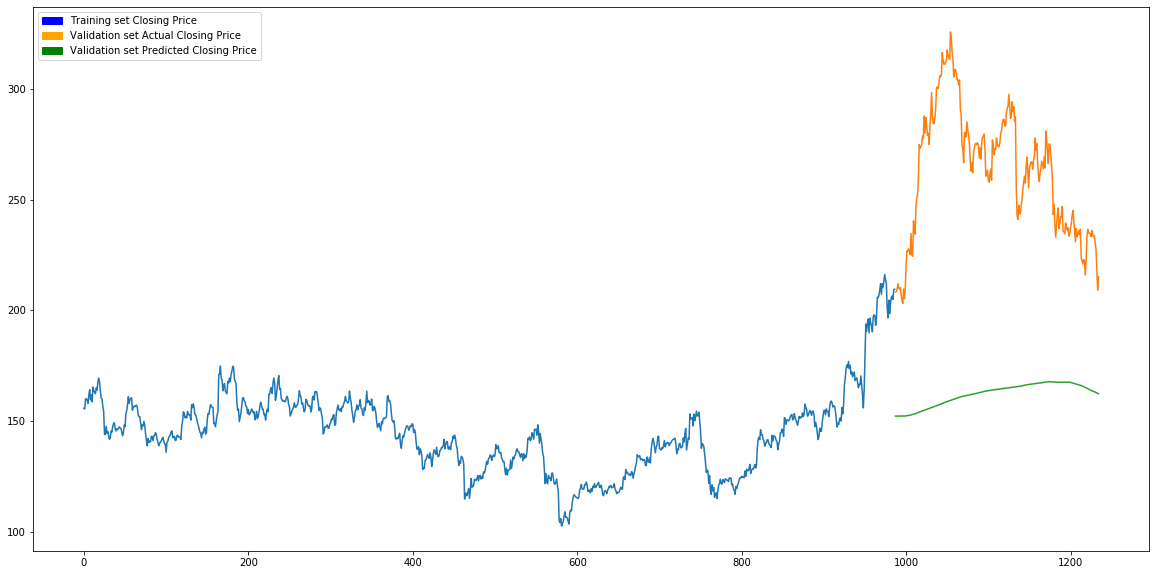

In [617]:
# observing rmse value of the plot
# plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
# valid['Close']
# valid['Predictions']

# labeling 
blue_patch = mpatches.Patch(color='blue', label='Training set Closing Price')
plt.legend(handles=[blue_patch])

orange_patch = mpatches.Patch(color='orange', label='Validation set Actual Closing Price')
plt.legend(handles=[orange_patch])

green_patch = mpatches.Patch(color='green', label='Validation set Predicted Closing Price')
plt.legend(handles=[blue_patch, orange_patch, green_patch])


### This model had an R2 value of 0. That is 0% of variation in prices was explained by the moving averages.

## Approach 2: Using linear-regression to predict next-day price.

In [618]:
## returns the root-mean-squared-error b/w actual and predicted values
def rmse(true, predicted):
    return (np.mean((true - predicted) ** 2)) ** 0.5

In [619]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

lr = LinearRegression()
X = df[['Last', 'Last Total Vol. Traded', 'Last Turnover (100,000 INR)']].sort_index()
y = df.Close.sort_index()
X_train, X_test, y_train, y_test = X[:987], X[987:], y[:987], y[987:]
lr.fit(X_train, y_train)

y_train_predicted = lr.predict(X_train)
y_test_predicted = lr.predict(X_test)

rmse_train = rmse(y_train, y_train_predicted)
rmse_train

rmse_test = rmse(y_test, y_test_predicted)
rmse_test


y_test.index = [i for i in range(987,1235)]
y_test_predicted = pd.Series(y_test_predicted)
y_test_predicted.index = [i for i in range(987,1235)]
y_test_predicted

print("RMSE: " + str(rmse_test))
# print("R2 value: :" +str(lr.score(X_test, y_test)))

RMSE: 0.6452680918883508


### A Linear Regression using 'Last Day' Price, Total Volume of Trade and Turnover certainly outperforms our naive assumption. 

### We get a validation set RMSE of 0.645 compared to a previous RMSE of 104.51

## Approach 3: Building a Long-Short Term Memory (LSTM) model to capture seasonality of price-movements

In [620]:
import sys
#!{sys.executable} -m pip install keras --user
#!conda install -c conda-forge keras -y -h
#!conda update -n base conda -y
#!pip install --upgrade keras --user

In [621]:
# Now to estimate rms using Long Short Term Memory (LSTM) model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# creating dataframe 
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

# inserting "Date" & "Close" values from data into new_data
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

# fixing "Date" as index of new_data
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
new_data

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45
...,...
2018-10-01,230.9
2018-10-03,227.6
2018-10-04,218.2


In [622]:
dataset = new_data.values
#splitting new_data into train and test sets
train = dataset[:987, :]
test = dataset[987:, :]

# conveting data into x_train and y_train
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

# scaled_data
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Fitting the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# using past 60 values from train set, predicting later 240 values
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
#inputs
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60 : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price

Epoch 1/1
 - 112s - loss: 0.0011


array([[194.67795],
       [195.53946],
       [196.13736],
       [196.6428 ],
       [197.38579],
       [197.8711 ],
       [198.06935],
       [198.19485],
       [197.76599],
       [196.8375 ],
       [195.60683],
       [195.34836],
       [194.97089],
       [195.25041],
       [197.29962],
       [200.75777],
       [204.3701 ],
       [207.60681],
       [209.9243 ],
       [211.27057],
       [213.2868 ],
       [213.85268],
       [213.60207],
       [215.30203],
       [216.97409],
       [218.14236],
       [220.68192],
       [224.03065],
       [227.37314],
       [231.34625],
       [237.1725 ],
       [242.59766],
       [247.08968],
       [250.49083],
       [253.38629],
       [255.33527],
       [258.08945],
       [259.5313 ],
       [261.2297 ],
       [262.15942],
       [261.91   ],
       [261.31384],
       [259.87387],
       [259.6983 ],
       [260.75717],
       [263.72263],
       [265.4089 ],
       [265.79062],
       [265.4885 ],
       [265.3006 ],


In [623]:
# rms to calculate error between actual and predicted closing prices
print('\nRMSE value on validation set:')
print(rmse(test, closing_price))


RMSE value on validation set:
20.815792948980654


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


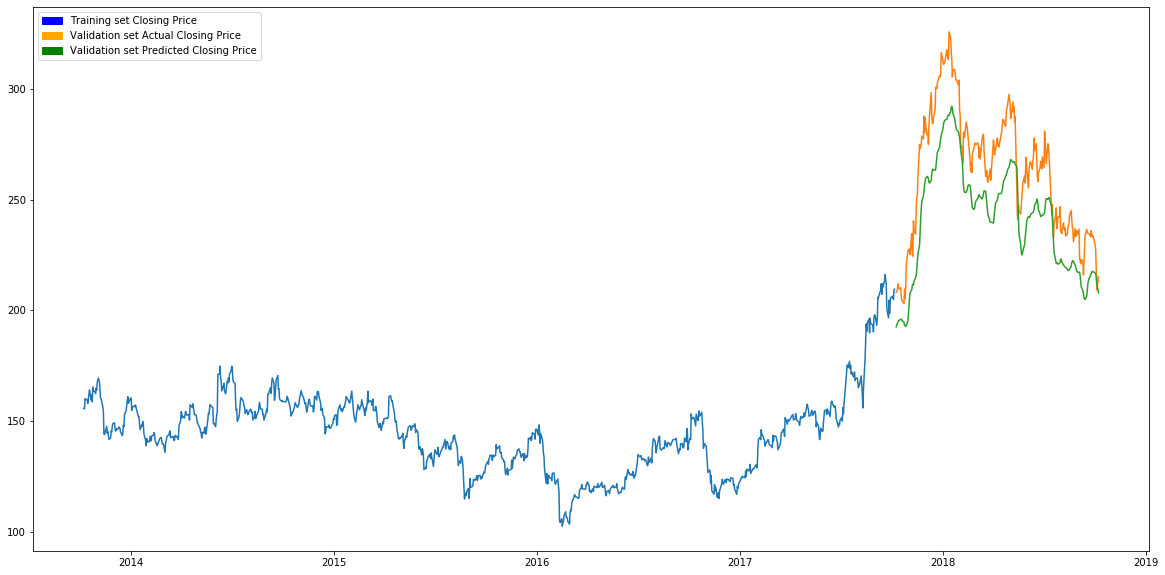

In [609]:
# plotting predicted closing price (green) alongside actual closing price (yellow) 
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
valid

# model.score(x_test, closing_price)
from sklearn.metrics import r2_score
r2_score(valid.Close, valid.Predictions)

# labeling 
blue_patch = mpatches.Patch(color='blue', label='Training set Closing Price')
plt.legend(handles=[blue_patch])

orange_patch = mpatches.Patch(color='orange', label='Validation set Actual Closing Price')
plt.legend(handles=[orange_patch])

green_patch = mpatches.Patch(color='green', label='Validation set Predicted Closing Price')
plt.legend(handles=[blue_patch, orange_patch, green_patch])


The validation set RMSE of LSTM shows us that this model predicts "long-term" price movements efficiently with the simplest feature space. 

However, LSTM is worse for intra-day trading in comparison with the linear-regression model as it leads to some bias when it predicts the "next-day price". 

The linear-regression model, although highly accurate for short term strategies, requires data related to the Total Volume Traded and the Turnover from the previous day.

In [542]:
# TECHNIQUE: Using current closing price and the SD of closing prices of a 'past-period' eg. 50 days to predic the price range
# of a stock tomorrow (setting a lower and upper bound of the stock price tomorrrow)

## A more general approach: 

## Creating 'price-bands' to predict future stock prices using today's features

In [543]:
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [544]:
df.Date = pd.to_datetime(df.Date)
asint =  df.Date.astype(int).sort_values()

In [545]:
df = df.assign(time = asint)
df_dated = df.set_index('Date')
df_dated = df_dated.sort_index().reset_index()
# df_dated.head(105)

In [546]:
features = df_dated.drop('Date', axis=1)
# scaler.fit(features.values)

In [547]:
def period_std_dev(row):
    """
    Returns the standard deviation of the "Closing-Day" prices
    of a stock within a certain time-frame.
    """
    lower_b = row['time'] - ticks_within_period
    upper_b = row['time']
    period_std = features.loc[(lower_b <= features.time) & (features.time <= upper_b)]['Close'].std()
    return period_std

std_along_period = features.apply(period_std_dev, axis=1)

In [548]:
df_dated = df_dated.assign(std_along_period = features.apply(period_std_dev, axis=1))

In [549]:
l_est = (df_dated.Close - 0.35 * df_dated.std_along_period) - 0.025 * df_dated.Close
u_est = (df_dated.Close + 0.35 * df_dated.std_along_period) + 0.025 * df_dated.Close
df_dated = df_dated.assign(lower_est_tomorrow = l_est)
df_dated = df_dated.assign(upper_est_tomorrow = u_est)
df_dated.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),time,std_along_period,lower_est_tomorrow,upper_est_tomorrow
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,1381190400000000000,NaN,NaN,NaN
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,1381276800000000000,0.176777,151.599378,159.500622
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,1381363200000000000,2.586665,155.240917,165.059083
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,1381449600000000000,2.557139,155.153751,164.946249
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,1381708800000000000,2.322176,154.650989,164.249011


In [550]:
# df_dated.dtypes

In [551]:
# df_dated.take(np.arange(1050, 1100))

In [552]:
# Using current closing price and the PERCENT CHANGES of closing prices of a 'past-period' eg. 50 days to predic the price range
# of a stock tomorrow (setting a lower and upper bound of the stock price tomorrrow)

In [553]:
def moving_ave(row, n=50):
    """
    Calculates the "moving average" of a stock over an 'n' day period.
    The default value of n = 50.
    
    """
    relevant_df = df_dated.take(np.arange(max(0, row.name - n), row.name + 1))
    simple_moving_ave = relevant_df['Close'].mean()
    
    return simple_moving_ave


In [554]:
features.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),time
0,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,1381190400000000000
1,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,1381276800000000000
2,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,1381363200000000000
3,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,1381449600000000000
4,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,1381708800000000000


In [555]:
df_dated = df_dated.assign(moving_ave_50 = features.apply(moving_ave, axis=1))
df_dated.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),time,std_along_period,lower_est_tomorrow,upper_est_tomorrow,moving_ave_50
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,1381190400000000000,NaN,NaN,NaN,155.800000
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,1381276800000000000,0.176777,151.599378,159.500622,155.675000
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,1381363200000000000,2.586665,155.240917,165.059083,157.166667
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,1381449600000000000,2.557139,155.153751,164.946249,157.887500
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,1381708800000000000,2.322176,154.650989,164.249011,158.200000


In [556]:
df_dated = df_dated.assign(moving_ave_20 = features.apply(moving_ave, n=20, axis=1))
df_dated = df_dated.assign(moving_ave_200 = features.apply(moving_ave, n=200, axis=1))

## Long-term moving averages help in decoding the overall trend of the stock market which may be obscured due to short-term "noise"

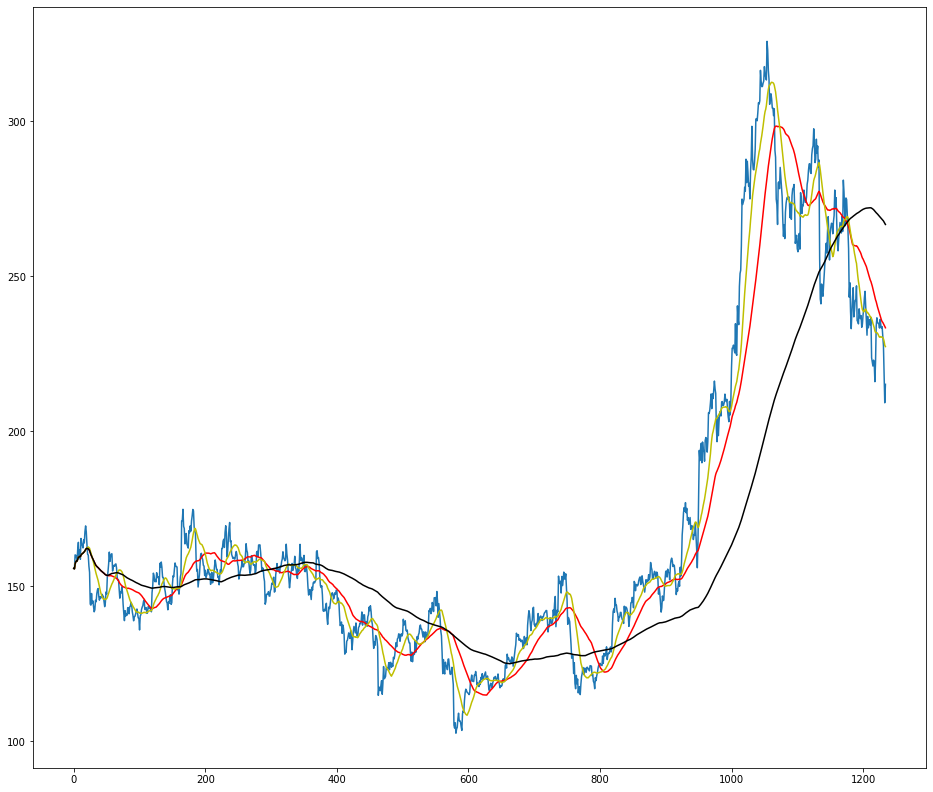

In [557]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 14
plt.rcParams["figure.figsize"] = fig_size

plt.plot(df_dated.Close)
plt.plot(df_dated.moving_ave_50, c='r')
plt.plot(df_dated.moving_ave_20, c = 'y')
plt.plot(df_dated.moving_ave_200, c = 'black')
plt.show()

In [558]:
df_dated.loc[1000].head()

Date    2017-10-27 00:00:00
Open                  211.3
High                  221.8
Low                  209.75
Last                  221.7
Name: 1000, dtype: object

### Simply observing the Total Trade Qunatity can reveal hints about future price-movements 

If we were to only look at the graph below, we can see that high volume traded almost always preceedes an upswing in price movement. 

However, the magnitude of the upswing is not clearly revealed.

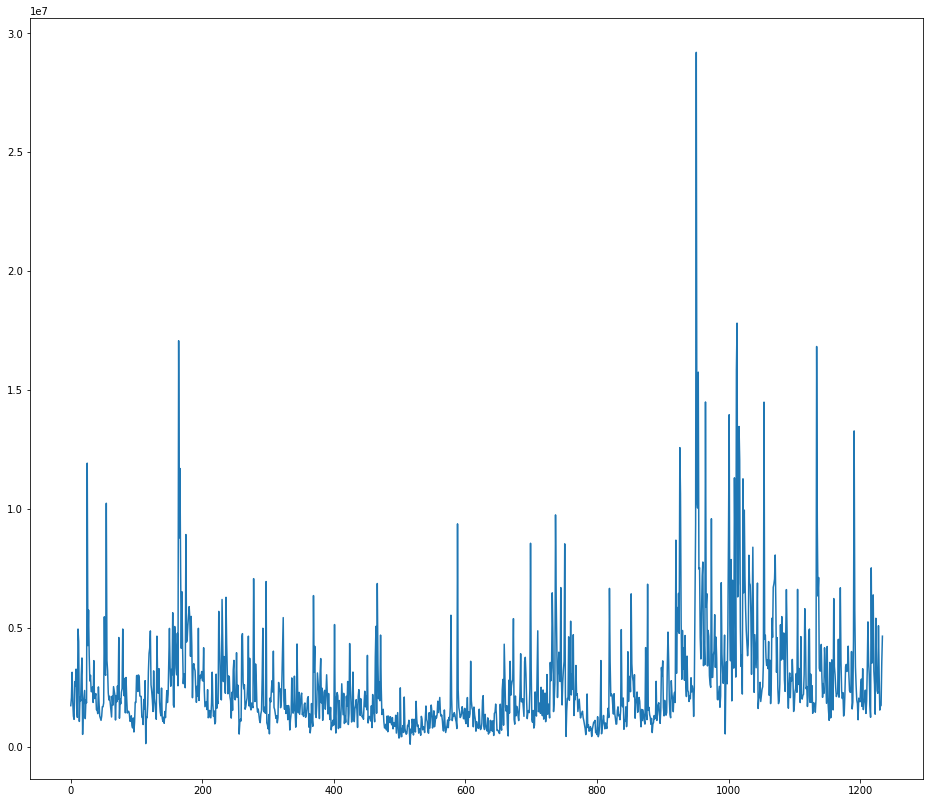

In [559]:
plt.plot(df_dated['Total Trade Quantity'])

In [560]:
def exp_moving_ave(row, n, df):
    """
    Returns the exponential moving averages over a "n-day" period in a df
    
    """
    relevant_df = df.take(np.arange(max(0, row.name - n), row.name + 1))
    indices = relevant_df.index

    k = 2/(n + 1)
    
    # Note: the starting point of all the EMAs over the period is simply the simple moving average
    ema = relevant_df.Close.mean()# relevant_df.loc[indices[0], 'Close']
    j = 0
    if len(indices) > 1:
        for index in indices[1:]:
            price_today = relevant_df.loc[index, 'Close']
            ema = (price_today * k) + (ema * (1 - k))        
    return ema


df_dated.apply(exp_moving_ave, n=26, df = df_dated, axis=1).head()


0    155.800000
1    155.665741
2    157.276772
3    158.054417
4    158.387490
dtype: float64

In [561]:
# creating a df with 13,21 day exponential moving averages
df_dated = df_dated.assign(exp_moving_ave_13 = df_dated.apply(exp_moving_ave, n=13, df = df_dated, axis=1))
df_dated = df_dated.assign(exp_moving_ave_21 = df_dated.apply(exp_moving_ave, n=21, df = df_dated, axis=1))
df_dated = df_dated.assign(exp_moving_ave_50 = df_dated.apply(exp_moving_ave, n=50, df = df_dated, axis=1))
df_dated.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),time,std_along_period,lower_est_tomorrow,upper_est_tomorrow,moving_ave_50,moving_ave_20,moving_ave_200,exp_moving_ave_13,exp_moving_ave_21,exp_moving_ave_50
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,1381190400000000000,NaN,NaN,NaN,155.800000,155.800000,155.800000,155.800000,155.800000,155.800000
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,1381276800000000000,0.176777,151.599378,159.500622,155.675000,155.675000,155.675000,155.657143,155.663636,155.670098
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,1381363200000000000,2.586665,155.240917,165.059083,157.166667,157.166667,157.166667,157.394898,157.304270,157.222748
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,1381449600000000000,2.557139,155.153751,164.946249,157.887500,157.887500,157.887500,158.228134,158.095455,157.972932
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,1381708800000000000,2.322176,154.650989,164.249011,158.200000,158.200000,158.200000,158.571366,158.432037,158.297145


## Testing the 13/21 EMA strategy on our data set

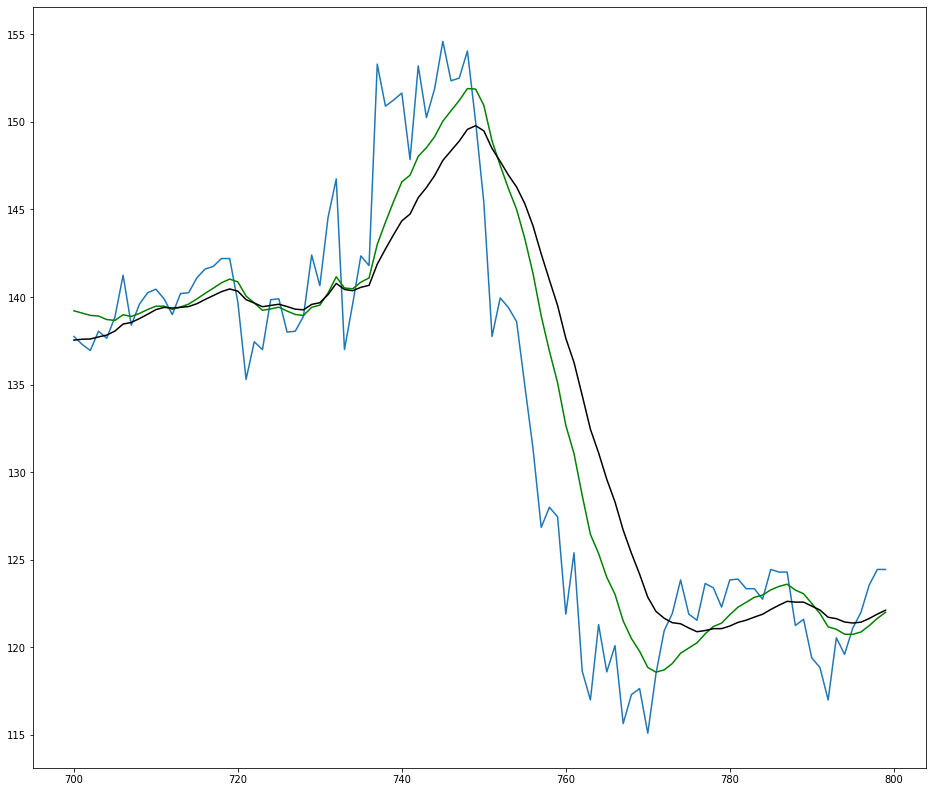

In [562]:
plt.plot(df_dated.Close[700:800])
plt.plot(df_dated.exp_moving_ave_13[700:800], c = 'g')
plt.plot(df_dated.exp_moving_ave_21[700:800], c = 'black')
#plt.plot(df_dated.exp_moving_ave_50, c = 'black')
plt.show()

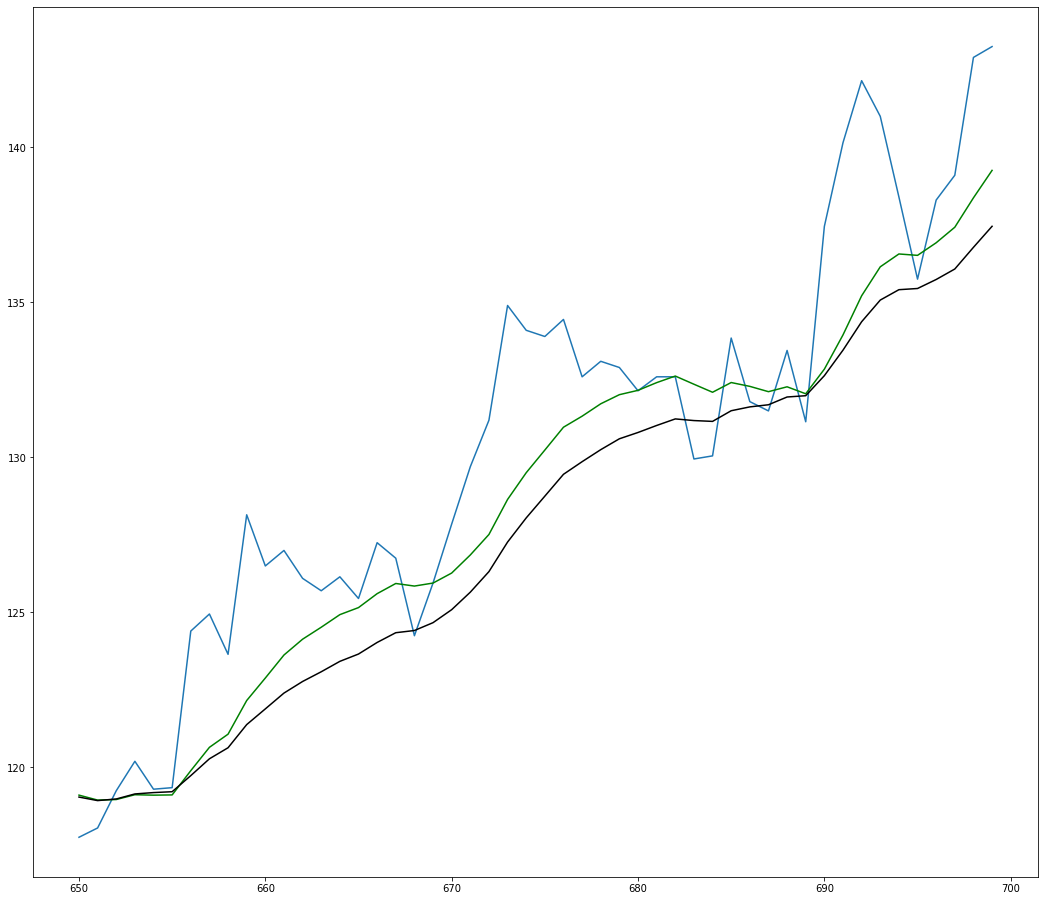

In [563]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 16
plt.rcParams["figure.figsize"] = fig_size

# PLOTTING THE 13EMA and 21EMA Strategy


# BUY: when the 13EMA (green) line is BELOW the 21EMA (red) line and a 'cross-over' is taking place

# SELL: inverse of buy strategy

plt.plot(df_dated.Close[650:700])
plt.plot(df_dated.exp_moving_ave_13[650:700], c = 'g')
plt.plot(df_dated.exp_moving_ave_21[650:700], c = 'black')
#plt.plot(df_dated.exp_moving_ave_50, c = 'black')
plt.show()

In [564]:
 def simple_moving_ave(row, df, n = 20):
    """
    Returns the simple moving average across "n" days
    
    """
    relevant_df = df.take(np.arange(max(0, row.name - n), row.name + 1))
    return relevant_df.Close.mean()

In [569]:
def bollinger_bands(row, df, n = 20, sd_factor = 2):
    """
    Returns the Bollinger Band corresponding to a certain stock-price value.
    
    Bollinger Bands are statistical constructs that act like a "confidence interval".
    For a certain stock-price, it creates a price-band 2 SDs above and below.
    
    """
    relevant_df = df.take(np.arange(max(0, row.name - n), row.name + 1))
    relevant_df_std = relevant_df['Close'].std()
    sma = simple_moving_ave(row, df, n)
    boll_lower = sma - sd_factor * (relevant_df_std)
    boll_upper = sma + sd_factor * (relevant_df_std)
    return [boll_lower, boll_upper]

bollinger_bands_values = df_dated.apply(bollinger_bands, df= df_dated, n=20, sd_factor = 2,axis=1)
# bollinger_bands_values

In [570]:
boll_lower = [val[0] for val in bollinger_bands_values]
boll_upper = [val[1] for val in bollinger_bands_values]
df_dated = df_dated.assign(boll_lower = boll_lower)
df_dated = df_dated.assign(boll_upper = boll_upper)
df_dated.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),time,std_along_period,lower_est_tomorrow,upper_est_tomorrow,moving_ave_50,moving_ave_20,moving_ave_200,exp_moving_ave_13,exp_moving_ave_21,exp_moving_ave_50,boll_lower,boll_upper
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94,1381190400000000000,NaN,NaN,NaN,155.800000,155.800000,155.800000,155.800000,155.800000,155.800000,NaN,NaN
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49,1381276800000000000,0.176777,151.599378,159.500622,155.675000,155.675000,155.675000,155.657143,155.663636,155.670098,155.321447,156.028553
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80,1381363200000000000,2.586665,155.240917,165.059083,157.166667,157.166667,157.166667,157.394898,157.304270,157.222748,151.993338,162.339996
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76,1381449600000000000,2.557139,155.153751,164.946249,157.887500,157.887500,157.887500,158.228134,158.095455,157.972932,152.773223,163.001777
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09,1381708800000000000,2.322176,154.650989,164.249011,158.200000,158.200000,158.200000,158.571366,158.432037,158.297145,153.555649,162.844351


In [571]:
df_dated

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),time,std_along_period,lower_est_tomorrow,upper_est_tomorrow,moving_ave_50,moving_ave_20,moving_ave_200,exp_moving_ave_13,exp_moving_ave_21,exp_moving_ave_50,boll_lower,boll_upper
0,2013-10-08,157.00,157.80,155.20,155.80,155.80,1720413.0,2688.94,1381190400000000000,NaN,NaN,NaN,155.800000,155.800000,155.800000,155.800000,155.800000,155.800000,NaN,NaN
1,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49,1381276800000000000,0.176777,151.599378,159.500622,155.675000,155.675000,155.675000,155.657143,155.663636,155.670098,155.321447,156.028553
2,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80,1381363200000000000,2.586665,155.240917,165.059083,157.166667,157.166667,157.166667,157.394898,157.304270,157.222748,151.993338,162.339996
3,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76,1381449600000000000,2.557139,155.153751,164.946249,157.887500,157.887500,157.887500,158.228134,158.095455,157.972932,152.773223,163.001777
4,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09,1381708800000000000,2.322176,154.650989,164.249011,158.200000,158.200000,158.200000,158.571366,158.432037,158.297145,153.555649,162.844351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05,1538352000000000000,6.764509,222.759922,239.040078,235.121569,230.209524,268.140050,232.724072,231.394854,233.440761,217.085743,243.333304
1231,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27,1538524800000000000,6.814119,219.525058,235.674942,234.723529,229.809524,267.837313,232.339380,230.938468,233.139136,216.916983,242.702065
1232,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79,1538611200000000000,7.196496,210.226226,226.173774,234.322549,229.042857,267.438557,230.513691,229.619386,232.507649,215.380050,242.705664
1233,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06,1538697600000000000,8.107810,201.132267,217.267733,233.853922,227.733333,267.047512,227.297833,227.517777,231.507523,212.033291,243.433376


### Bollinger Bands have a "corrective" effect on stock prices. 

Whenever a stock price breaches the BB, it is a sign that the stock will retrace its movement.

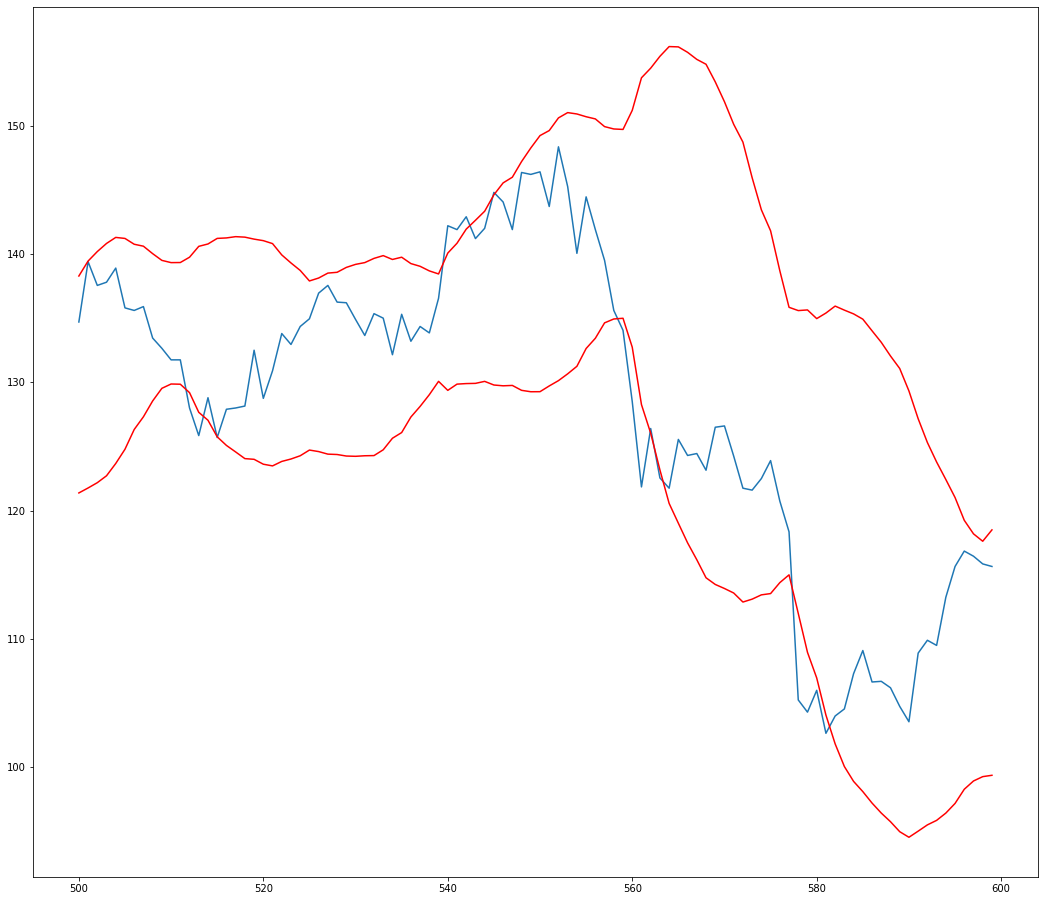

In [572]:
plt.plot(df_dated.Close[500:600])
plt.plot(df_dated.boll_lower[500:600], c='red')
plt.plot(df_dated.boll_upper[500:600], c = 'red')

plt.show()

# Putting our theory to the test

## how our trading strategy fares on Apple (AAPL) stock prices 
 

In [573]:
apl_df = pd.read_csv('EOD-AAPL.csv')
apl_df = apl_df.set_index('Date').sort_index().reset_index()
apl_df

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2013-09-03,493.10,500.600,487.350,488.580,11854600.0,0.0,1.0,63.019032,63.977544,62.284172,62.441368,82982200.0
1,2013-09-04,499.56,502.240,496.280,498.691,12322600.0,0.0,1.0,63.844631,64.187139,63.425441,63.733571,86258200.0
2,2013-09-05,500.25,500.680,493.640,495.270,8441700.0,0.0,1.0,63.932814,63.987769,63.088044,63.296361,59091900.0
3,2013-09-06,498.44,499.380,489.950,498.220,12840200.0,0.0,1.0,63.701493,63.821626,62.616456,63.673376,89881400.0
4,2013-09-09,505.00,507.920,503.480,506.170,12167400.0,0.0,1.0,64.539872,64.913053,64.345613,64.689400,85171800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,2017-12-21,174.17,176.020,174.100,175.010,20949896.0,0.0,1.0,169.047981,170.843576,168.980040,169.863278,20949896.0
1086,2017-12-22,174.68,175.424,174.500,175.010,16349444.0,0.0,1.0,169.542983,170.265103,169.368277,169.863278,16349444.0
1087,2017-12-26,170.80,171.470,169.679,170.570,33185536.0,0.0,1.0,165.777087,166.427383,164.689053,165.553851,33185536.0
1088,2017-12-27,170.10,170.780,169.710,170.600,21498213.0,0.0,1.0,165.097672,165.757675,164.719142,165.582968,21498213.0


In [574]:
apl_df = apl_df.assign(exp_moving_ave_13 = apl_df.apply(exp_moving_ave, n = 13, df = apl_df, axis=1))
apl_df = apl_df.assign(exp_moving_ave_21 = apl_df.apply(exp_moving_ave, n = 21, df = apl_df, axis=1))
apl_df.head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,exp_moving_ave_13,exp_moving_ave_21
0,2013-09-03,493.10,500.60,487.35,488.580,11854600.0,0.0,1.0,63.019032,63.977544,62.284172,62.441368,82982200.0,488.580000,488.580000
1,2013-09-04,499.56,502.24,496.28,498.691,12322600.0,0.0,1.0,63.844631,64.187139,63.425441,63.733571,86258200.0,494.357714,494.095091
2,2013-09-05,500.25,500.68,493.64,495.270,8441700.0,0.0,1.0,63.932814,63.987769,63.088044,63.296361,59091900.0,494.888327,494.652176
3,2013-09-06,498.44,499.38,489.95,498.220,12840200.0,0.0,1.0,63.701493,63.821626,62.616456,63.673376,89881400.0,496.000262,495.735289
4,2013-09-09,505.00,507.92,503.48,506.170,12167400.0,0.0,1.0,64.539872,64.913053,64.345613,64.689400,85171800.0,498.638401,498.183763


In [575]:
apl_df.loc[1020].head()

Date     2017-09-20
Open          157.9
High         158.26
Low          153.83
Close        156.07
Name: 1020, dtype: object

In [576]:
apl_df.loc[len(apl_df) - 1].head()

Date     2017-12-28
Open            171
High         171.85
Low          170.48
Close        171.08
Name: 1089, dtype: object

### Exhibit 1: APPL stock prices from September 20 2017 -  December 28 2017

### Trading strategy using a 13/21 EMA strategy

BUY: When the `green` line is BELOW the `red` line during a 'cross-over'

SELL: When the `green` line is ABOVE the `red` line during a 'cross-over'

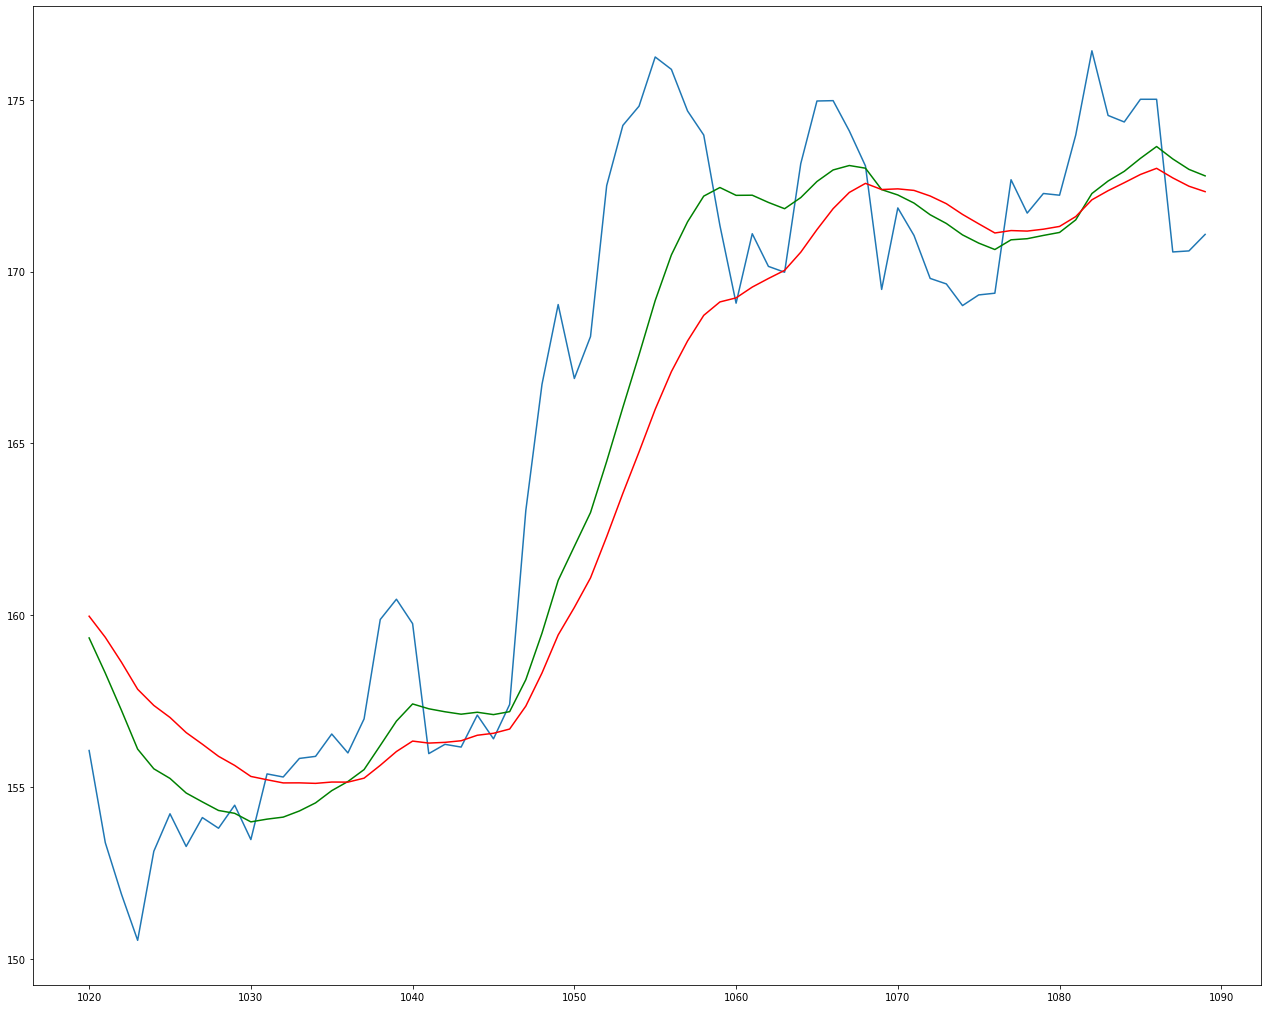

In [577]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 22
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size

# PLOTTING THE 13EMA and 21EMA Strategy


# BUY: when the 13EMA (green) line is BELOW the 21EMA (red) line and a 'cross-over' is taking place

# SELL: inverse of buy strategy

plt.plot(apl_df.Close[1020:])
plt.plot(apl_df.exp_moving_ave_13[1020:], c = 'g')
plt.plot(apl_df.exp_moving_ave_21[1020:], c = 'r')
#plt.plot(apl_df.exp_moving_ave_50, c = 'black')
plt.show()

In [578]:
# df_dated

In [579]:
bollinger_bands_apl = apl_df.apply(bollinger_bands, df= apl_df, n=20, sd_factor = 2,axis=1)
bollinger_bands_apl

0                                     [nan, nan]
1        [479.3363866708456, 507.93461332915433]
2         [483.8946908481342, 504.4659758185324]
3        [485.87099389592527, 504.5095061040747]
4       [484.67477487140013, 510.09762512859993]
                          ...                   
1085     [167.76378618699044, 176.9752614320571]
1086     [167.7604944828356, 176.98331504097393]
1087    [167.64795117770552, 176.67681072705642]
1088    [167.52303286130376, 176.46934809107722]
1089     [167.4395129034031, 176.36334423945408]
Length: 1090, dtype: object

In [580]:
boll_lower = [val[0] for val in bollinger_bands_apl]
boll_upper = [val[1] for val in bollinger_bands_apl]
apl_df = apl_df.assign(boll_lower = boll_lower)
apl_df = apl_df.assign(boll_upper = boll_upper)
apl_df = apl_df.assign(moving_ave_20 = apl_df.apply(simple_moving_ave, n = 20, df = apl_df, axis=1))
apl_df = apl_df.assign(moving_ave_10 = apl_df.apply(simple_moving_ave, n = 10, df = apl_df, axis=1))

apl_df = apl_df.assign(exp_moving_ave_5 = apl_df.apply(exp_moving_ave, n = 5, df = apl_df, axis = 1))
apl_df = apl_df.assign(exp_moving_ave_10 = apl_df.apply(exp_moving_ave, n = 10, df = apl_df, axis = 1))
apl_df

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,...,Adj_Close,Adj_Volume,exp_moving_ave_13,exp_moving_ave_21,boll_lower,boll_upper,moving_ave_20,moving_ave_10,exp_moving_ave_5,exp_moving_ave_10
0,2013-09-03,493.10,500.600,487.350,488.580,11854600.0,0.0,1.0,63.019032,63.977544,...,62.441368,82982200.0,488.580000,488.580000,NaN,NaN,488.580000,488.580000,488.580000,488.580000
1,2013-09-04,499.56,502.240,496.280,498.691,12322600.0,0.0,1.0,63.844631,64.187139,...,63.733571,86258200.0,494.357714,494.095091,479.336387,507.934613,493.635500,493.635500,495.320667,494.554682
2,2013-09-05,500.25,500.680,493.640,495.270,8441700.0,0.0,1.0,63.932814,63.987769,...,63.296361,59091900.0,494.888327,494.652176,483.894691,504.465976,494.180333,494.180333,495.545926,495.049463
3,2013-09-06,498.44,499.380,489.950,498.220,12840200.0,0.0,1.0,63.701493,63.821626,...,63.673376,89881400.0,496.000262,495.735289,485.870994,504.509506,495.190250,495.190250,496.736519,496.179064
4,2013-09-09,505.00,507.920,503.480,506.170,12167400.0,0.0,1.0,64.539872,64.913053,...,64.689400,85171800.0,498.638401,498.183763,484.674775,510.097625,497.386200,497.386200,500.314780,498.979658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,2017-12-21,174.17,176.020,174.100,175.010,20949896.0,0.0,1.0,169.047981,170.843576,...,169.863278,20949896.0,173.291917,172.823064,167.763786,176.975261,172.369524,172.894545,174.786571,173.888834
1086,2017-12-22,174.68,175.424,174.500,175.010,16349444.0,0.0,1.0,169.542983,170.265103,...,169.863278,16349444.0,173.636119,173.001970,167.760494,176.983315,172.371905,173.411818,174.941962,174.248366
1087,2017-12-26,170.80,171.470,169.679,170.570,33185536.0,0.0,1.0,165.777087,166.427383,...,165.553851,33185536.0,173.274952,172.723445,167.647951,176.676811,172.162381,173.520909,173.342565,173.612369
1088,2017-12-27,170.10,170.780,169.710,170.600,21498213.0,0.0,1.0,165.097672,165.757675,...,165.582968,21498213.0,172.971331,172.481451,167.523033,176.469348,171.996190,173.332727,172.290837,173.083875


## Exhibit 2: AAPL stock prices from March 25 2014 to May 21 2014

### Price movements are reversed after breaching the "Bollinger Lines" (in gray).


When the price moves upward and breaches the upper-band, it has a tendency to "correct" itself and retrace its movement.

The same principle can be observed when the price breaches the band from below.

In [581]:
apl_df.loc[140].head()

Date     2014-03-25
Open          541.5
High         545.75
Low          539.59
Close        544.99
Name: 140, dtype: object

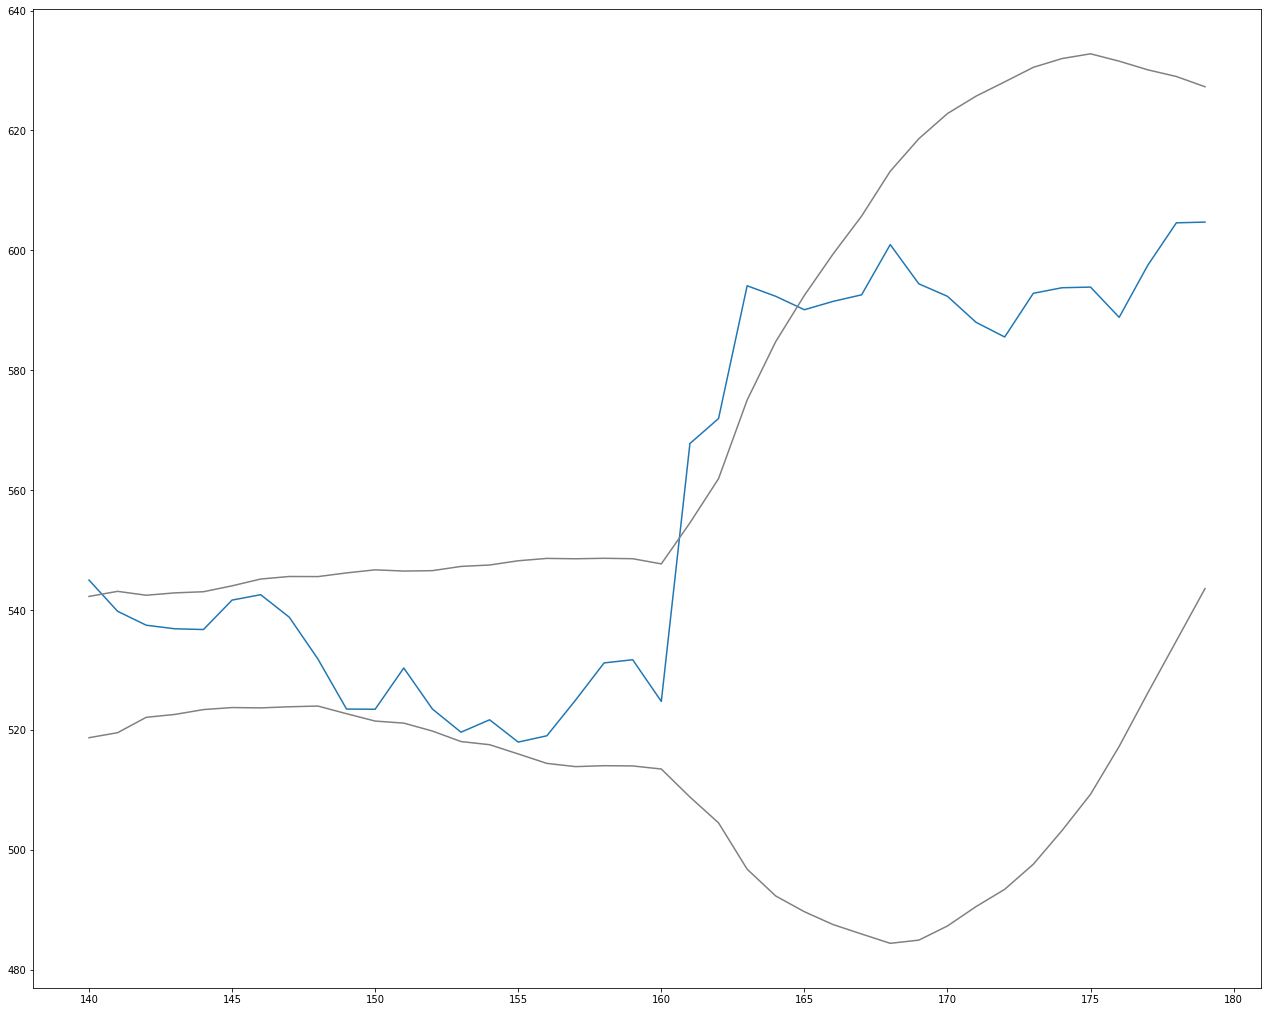

In [582]:
plt.plot(apl_df.Close[140:180])

### 13/21 EMAs ###
# plt.plot(apl_df.exp_moving_ave_13[140:180], c = 'g')
# plt.plot(apl_df.exp_moving_ave_21[140:180], c = 'r')

### Bollinger Bands ###
plt.plot(apl_df.boll_lower[140:180], c = 'gray')
plt.plot(apl_df.boll_upper[140:180], c = 'gray')
plt.show()

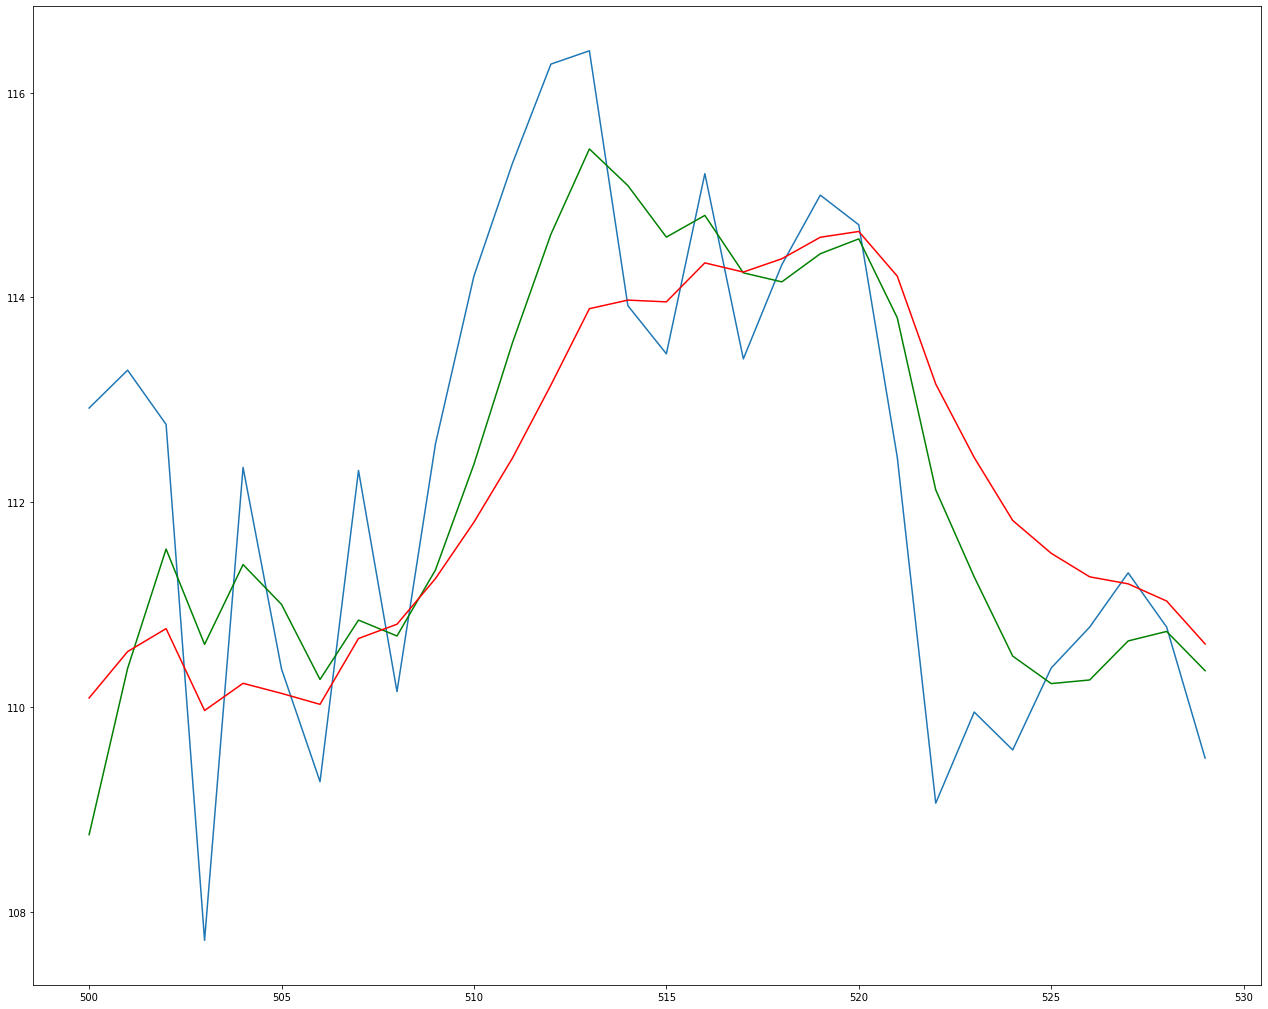

In [583]:
plt.plot(apl_df.Close[500:530])
plt.plot(apl_df.exp_moving_ave_5[500:530], c = 'g')
plt.plot(apl_df.exp_moving_ave_10[500:530], c = 'r')
#plt.plot(apl_df.exp_moving_ave_50, c = 'black')
# plt.plot(apl_df.moving_ave_10[900:920], c = 'black')
# plt.plot(apl_df.boll_lower[900:920], c = 'r')
# plt.plot(apl_df.boll_upper[900:920], c = 'r')
plt.show()

## Exhibit 3: AAPL Stock prices from Jan 21 2016 to March 04 2016

### The 13/21 EMA strategy can be seen in action here as well

BUY: When the `green` line is BELOW the 'red' line during a 'crossover'

SELL: When the `green` line is ABOVE the 'red' line during a 'crossover'

In [584]:
apl_df.loc[630].head()

Date     2016-03-04
Open         102.37
High         103.75
Low          101.37
Close        103.01
Name: 630, dtype: object

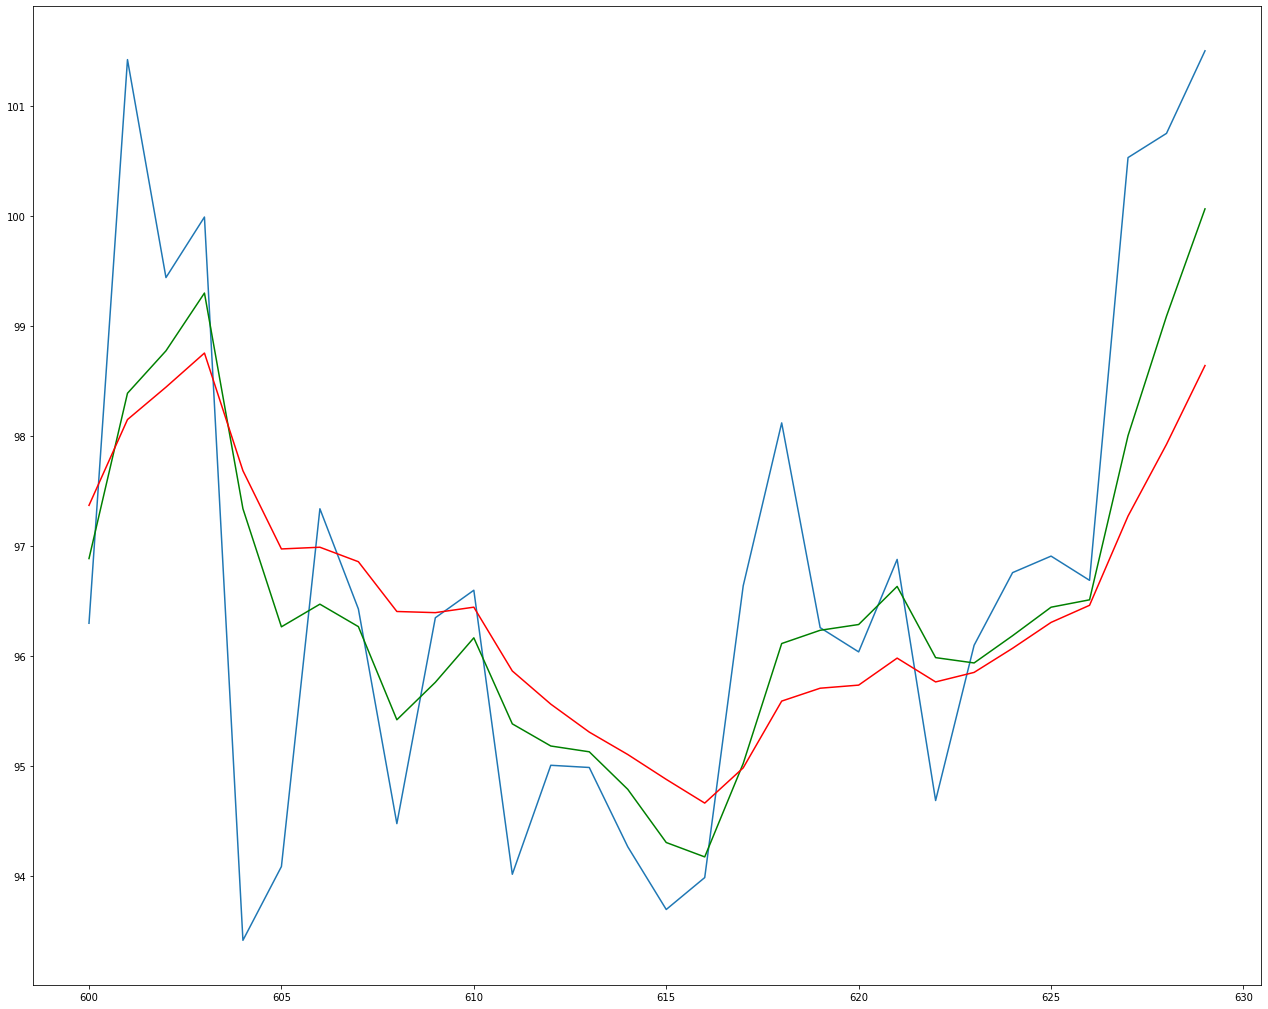

In [585]:
plt.plot(apl_df.Close[600:630])
plt.plot(apl_df.exp_moving_ave_5[600:630], c = 'g')
plt.plot(apl_df.exp_moving_ave_10[600:630], c = 'r')